In [73]:
import pandas as pd
import numpy as np
import plotly.express as px
df = pd.read_csv('data.csv')
print(df.columns)

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo'],
      dtype='object')


In [74]:
%load_ext tensorboard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
filtered_df = df.copy()
filtered_df['artists'] = filtered_df['artists'].apply(lambda x: x[1:-1].replace("'", ""))
art = filtered_df['artists'].sample()
print(len(art))
print(art.values[0])#.index[0]

1
Toni Braxton


In [3]:
filtered_df = filtered_df.drop(columns=['id']) #we dont need the spotify id's 
# remastered_list = [x for x in filtered_df.name if "remaster" in x.lower()]
# len(remastered_list)
# filtered_df = filtered_df[~filtered_df.name.isin(remastered_list)] # all the songs without the remastered 

# #are there any songs with the named remaster im discriminating against?
# #should i just get rid of everything remastered?

# skits_list = [x for x in filtered_df.name if "skit" in x.lower()]
# filtered_df = filtered_df[~filtered_df.name.isin(skits_list)]
# #28 skits a few are actual songs but idt they will be impactful

# demo_list = [x for x in filtered_df.name if "demo " in x.lower()]
# filtered_df = filtered_df[~filtered_df.name.isin(demo_list)]

In [4]:
filenames = ['classical_idx.csv','hip-hop_idx.csv','jazz_idx.csv','metal_idx.csv','reggae_idx.csv','rock_idx.csv']

gen = pd.DataFrame(0, index=np.arange(filtered_df.shape[0]),columns=['genera'])

#filtered_data['genera'] = 
for n in filenames:
    gen.iloc[pd.read_csv('genera_csv/'+n, header=None).iloc[:,0]] = n[:-8]

In [5]:
final_df = filtered_df.join(gen)
labeled_data = final_df[final_df.genera != 0]
unlabeled_data = final_df[final_df.genera == 0]

In [6]:
y = labeled_data.genera
features_list = ['valence', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']
X = labeled_data.copy()#[features_list].copy()
Z = unlabeled_data.copy()#[features_list].copy()

In [38]:
from sklearn.preprocessing import MinMaxScaler
to_norm_list = ['duration_ms', 'key','loudness', 'popularity', 'tempo']

scaler = MinMaxScaler(feature_range=(0, 1))
d = scaler.fit_transform(X[to_norm_list])
scaled_df = pd.DataFrame(d, columns=to_norm_list)
scaled_df.head()
X.drop(to_norm_list, axis=1,inplace=True)
X = X.reset_index(drop=True)
X[to_norm_list] = scaled_df
y



137       classical
229            jazz
806            jazz
814            jazz
1409           jazz
            ...    
167324       reggae
167516       reggae
168592         rock
169414         jazz
169454    classical
Name: genera, Length: 606, dtype: object

In [39]:
y.sample(20)

13908     hip-hop
15635      reggae
10807        rock
10956       metal
12113     hip-hop
33439     hip-hop
10857        rock
51652     hip-hop
8624         rock
29922        rock
9842         rock
66368      reggae
13630       metal
8450         jazz
14574     hip-hop
6421         jazz
6874         jazz
54783        jazz
14021     hip-hop
149886       jazz
Name: genera, dtype: object

In [45]:
y = pd.get_dummies(y)

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[features_list], y,test_size=0.2)


In [60]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential()
model.add(layers.Dense(units=6, input_shape=(len(features_list),)))
model.add(layers.Dense(units=6))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy', 'mse'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 6)                 78        
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 42        
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [70]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=20)

Train on 484 samples, validate on 122 samples
Epoch 1/20
484/484 [==============================] - 0s 64us/sample - loss: 4.5747 - categorical_accuracy: 0.3058 - mean_squared_error: 0.2091 - val_loss: 4.6435 - val_categorical_accuracy: 0.3115 - val_mean_squared_error: 0.2165
Epoch 2/20
484/484 [==============================] - 0s 70us/sample - loss: 4.4628 - categorical_accuracy: 0.2955 - mean_squared_error: 0.2101 - val_loss: 4.6013 - val_categorical_accuracy: 0.2705 - val_mean_squared_error: 0.2172
Epoch 3/20
484/484 [==============================] - 0s 68us/sample - loss: 4.4566 - categorical_accuracy: 0.2934 - mean_squared_error: 0.2110 - val_loss: 4.5021 - val_categorical_accuracy: 0.2623 - val_mean_squared_error: 0.2180
Epoch 4/20
484/484 [==============================] - 0s 59us/sample - loss: 4.3929 - categorical_accuracy: 0.2913 - mean_squared_error: 0.2118 - val_loss: 4.6836 - val_categorical_accuracy: 0.2623 - val_mean_squared_error: 0.2189
Epoch 5/20
484/484 [==========

Minimum Validation Loss: 3.9789


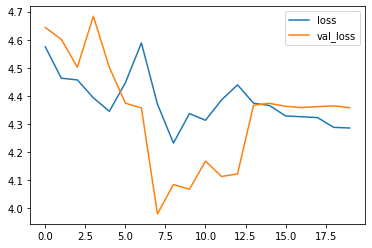

In [71]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

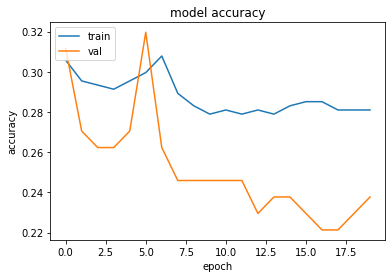

In [72]:
from matplotlib import pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [64]:
history.history

{'loss': [4.725958106931576,
  3.955738989774846,
  3.6987830351206883,
  3.4017083605458915,
  3.224616606373432,
  2.9364629451893576,
  2.907416065862356,
  2.7876831046805894,
  2.807782235224385,
  2.7284631098597503,
  2.7745862085957174,
  2.782978721886627,
  2.8290299610658125,
  2.7428568975984557,
  2.7089156927156055,
  2.834513332232956,
  2.8336462078015665,
  3.4427546095256965,
  3.5095048093598735,
  3.5865176334854],
 'categorical_accuracy': [0.17561984,
  0.17355372,
  0.16115703,
  0.1694215,
  0.16322315,
  0.1694215,
  0.1714876,
  0.1714876,
  0.15289256,
  0.1570248,
  0.16322315,
  0.16322315,
  0.16115703,
  0.18181819,
  0.17975207,
  0.17975207,
  0.18181819,
  0.16735537,
  0.1570248,
  0.17561984],
 'mean_squared_error': [0.21311386,
  0.20169346,
  0.19712049,
  0.1964429,
  0.19599873,
  0.19662441,
  0.19776359,
  0.19740868,
  0.19498242,
  0.19580486,
  0.19502014,
  0.19330871,
  0.19225793,
  0.19411731,
  0.19442053,
  0.19206819,
  0.19167463,
  0